In [57]:
import os
import glob

import hist
import boost_histogram as bh

import dask
import dask.array as da
import dask_histogram as dh
import uproot

from tqdm import tqdm

import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# Laden der Daten

In [59]:
data_path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution"
data_file_pattern = "1cmConcrete_*.root"

min_data_file_size = 5 * 1024 * 1024
data_files = glob.glob(f"{data_path}/{data_file_pattern}")
print(f"Found {len(data_files)} files matching pattern '{data_file_pattern}' in '{data_path}'.")

uproot_files = [{f:"events/events"} for f in data_files if os.path.getsize(f) > min_data_file_size]
print(f"Available keys in uproot files: {uproot.open(uproot_files[0]).keys()}")

columns = ["eventid", "e_pri", "xp_pri", "yp_pri", "zp_pri", "type_pri",
           "Save_x", "Save_y", "Save_z", "Save_e", "Save_desc", "Save_type",
           "NAct_volume", "NAct_x", "NAct_y", "NAct_z", "NAct_process", "NAct_name" ]

Found 20 files matching pattern '1cmConcrete_*.root' in '/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution'.
Available keys in uproot files: ['eventid', 'type_pri', 'e_pri', 'xp_pri', 'yp_pri', 'zp_pri', 'cx_pri', 'cy_pri', 'cz_pri', 'vol_pri', 'NSave', 'Save_flag', 'Save_desc', 'Save_type', 'Save_x', 'Save_y', 'Save_z', 'Save_cx', 'Save_cy', 'Save_cz', 'Save_e', 'Save_t', 'Save_eventid', 'Save_trackid', 'NNAct', 'NAct_volume', 'NAct_name', 'NAct_x', 'NAct_y', 'NAct_z', 'NAct_process', 'NAct_atomicnumber', 'NAct_mass', 'NAct_eventid', 'NAct_t', 'NAct_lifetime', 'NAct_excitation_energy']


In [60]:
data = uproot.dask(uproot_files, filter_name=columns, cut=None , allow_missing=True, step_size="2GB")

# Position

In [103]:
neutron_mask = ak.ravel(data["type_pri"].compute()) == "neutron"

x_range = (ak.min(ak.ravel(data["xp_pri"])).compute(), ak.max(ak.ravel(data["xp_pri"])).compute())
y_range = (ak.min(ak.ravel(data["yp_pri"])).compute(), ak.max(ak.ravel(data["yp_pri"])).compute())
z_range = (ak.min(ak.ravel(data["zp_pri"])).compute(), ak.max(ak.ravel(data["zp_pri"])).compute())

filtered_xp_pri = ak.ravel(da.where(data['type_pri'].compute() == "neutron",["xp_pri","yp_pri"]))
filtered_yp_pri = ak.ravel(data['yp_pri'].compute())
filtered_zp_pri = ak.ravel(ak.mask(data["zp_pri"].compute(), neutron_mask))

h = dh.histogramdd((filtered_xp_pri, filtered_yp_pri, filtered_zp_pri), 
                   bins=(100, 100, 100), 
                   range=(x_range, y_range, z_range), histogram=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(h.compute().sum(axis=2), extent=(x_range[0], x_range[1], y_range[0], y_range[1]), origin='lower', aspect='auto')
axs[0].set_xlabel('X Position (cm)')
axs[0].set_ylabel('Y Position (cm)')

axs[1].imshow(h.compute().sum(axis=1).T, extent=(x_range[0], x_range[1], z_range[0], z_range[1]), origin='lower', aspect='auto')
axs[1].set_xlabel('X Position (cm)')
axs[1].set_ylabel('Z Position (cm)')

plt.tight_layout()
plt.show()


ValueError: either both or neither of x and y should be given

# Alte Sachen

In [3]:
# Verbindung zur SQLite-Datenbank herstellen
db_path = "1cmConcrete.db"

conn = sqlite3.connect(db_path)


In [ ]:


db_path = "1cmConcrete.db"
os.remove(db_path)
conn = sqlite3.connect(db_path)

# Pfad für Dateien
path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution/1cmConcrete_*.root"

# Dateien abrufen und begrenzen auf die ersten zwei
files = glob.glob(path)[:5]
print(files)

# Chunk-Größe festlegen (z. B. 10.000 Events pro Patch)
batch_size = 100000

# Filter für die relevanten Felder
fields_to_filter = [
    "e_pri", "xp_pri", "yp_pri", "zp_pri", "type_pri",
    "Save_x", "Save_y", "Save_z", "Save_e", "Save_desc", "Save_type",
    "NAct_volume", "NAct_x", "NAct_y", "NAct_z", "NAct_process", "NAct_name",
]

# Dateien iterativ verarbeiten
for idx, file in enumerate(files, start=1):
    print(f"Processing file {idx}/{len(files)}: {file}")
    
    # Iteration über Events in Batches
    for batch in uproot.iterate(f"{file}:events/events", fields_to_filter, step_size=batch_size):
        print(f'Dataframes')
        df_pri = pd.DataFrame({
            "xp_pri": batch["xp_pri"].to_numpy(),
            "yp_pri": batch["yp_pri"].to_numpy(),
            "zp_pri": batch["zp_pri"].to_numpy(),
            "e_pri": batch["e_pri"].to_numpy(),
            "type_pri": aw.flatten(batch['type_pri']).to_numpy(),  # Flache Version von type_pri aus batch_flat
        })
        df_Save = pd.DataFrame({
            "Save_x": aw.flatten(batch["Save_x"]).to_numpy(),
            "Save_y": aw.flatten(batch["Save_y"]).to_numpy(),
            "Save_z": aw.flatten(batch["Save_z"]).to_numpy(),
            "Save_e": aw.flatten(batch["Save_e"]).to_numpy(),
            "Save_desc": aw.flatten(batch["Save_desc"]).to_numpy(),
            "Save_type": aw.flatten(batch["Save_type"]).to_numpy(),
        })
        df_NAct = pd.DataFrame({
            "NAct_volume": aw.flatten(batch["NAct_volume"]).to_numpy(),
            "NAct_x": aw.flatten(batch["NAct_x"]).to_numpy(),
            "NAct_y": aw.flatten(batch["NAct_y"]).to_numpy(),
            "NAct_z": aw.flatten(batch["NAct_z"]).to_numpy(),
            "NAct_process": aw.flatten(batch["NAct_process"]).to_numpy(),
            "NAct_name": aw.flatten(batch["NAct_name"]).to_numpy(),
        })

        print('To SQL')
        print('Primary')
        df_pri.to_sql("Primary", conn, if_exists="append", index=True)
        print('Save')
        df_Save.to_sql("Save", conn, if_exists="append", index=True)
        print('NAct')
        df_NAct.to_sql("NAct", conn, if_exists="append", index=True)

        print('Delete')
        # Speicher bereinigen
        del df_pri, df_Save, df_NAct
        gc.collect()

# Datenbankverbindung schließen
print("Processing completed.")


['/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution/1cmConcrete_9.root', '/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution/1cmConcrete_2.root', '/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution/1cmConcrete_10.root', '/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution/1cmConcrete_3.root', '/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution/1cmConcrete_0.root']
Processing file 1/5: /home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution/1cmConcrete_9.root
Dataframes
To SQL
Primary
Save
NAct
Delete
Processing file 2/5: /home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution/1cmConcrete_2.root
Dataframes
To SQL
Primary
Save
NAct
Delete
Processing file 3/5: /home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/4ddd64f/ConstantDistribution/1cmConcrete_10.root
Dataframes
To SQL
Primary
Save
NAct
Delete
Proces

## Postitions 2D


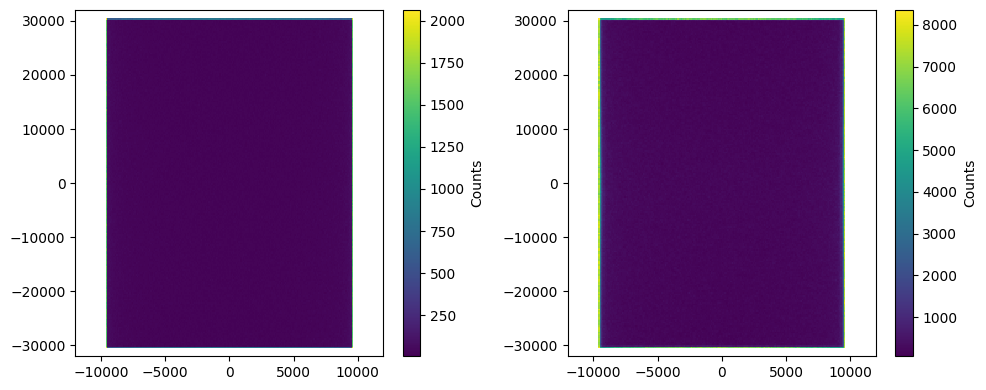

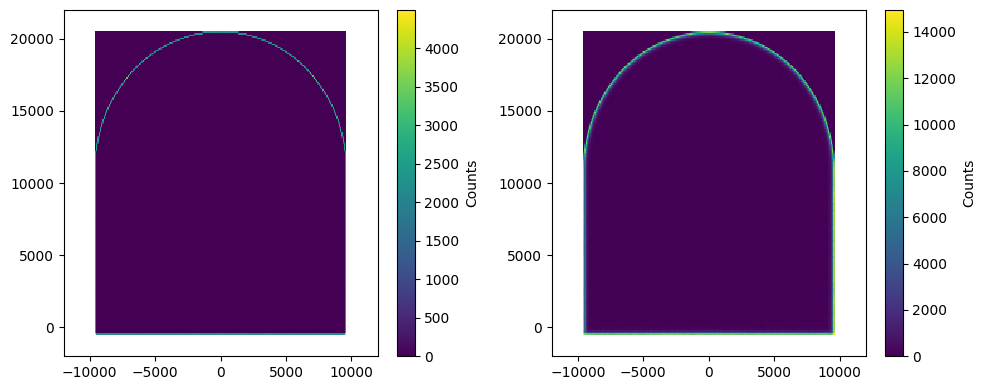

12306

In [ ]:
""" type_pri = aw.flatten(data['type_pri']) #Nur um extra kalmmer wegzukriegen [[neutron],...] -> [neutron,...]
                                        # Wichtig!!! Große Numpy array == großes Problem

x_pri, y_pri, z_pri = (aw.to_numpy(data[type_pri == 'neutron',f'{coord}']) for coord in ['xp_pri', 'yp_pri', 'zp_pri'])
x, y, z = (aw.to_numpy(aw.flatten(data[f'NAct_{coord}'])) for coord in ['x', 'y', 'z']) """

df_pri = pd.read_sql("SELECT xp_pri, yp_pri, zp_pri, type_pri FROM 'Primary'", conn)
df_NAct = pd.read_sql("SELECT NAct_x, NAct_y, NAct_z FROM 'NAct'", conn)




fig, axs = plt.subplots(1, 2, figsize=(10, 4))

bins = 200

im2 = axs[1].hist2d(df_NAct['NAct_x'],df_NAct['NAct_y'], bins=bins, cmap='viridis')  # 2D-Histogramm
im1 = axs[0].hist2d(df_pri['xp_pri'],df_pri['yp_pri'], bins=bins, cmap='viridis')  # 2D-Histogramm

# Farbleiste hinzufügen
cbar1 = fig.colorbar(im1[3], ax=axs[0], label='Counts')
cbar2 = fig.colorbar(im2[3], ax=axs[1], label='Counts')

axs[0].set_xlim(-12000, 12000)  # Beispielwerte für x-Range
axs[0].set_ylim(-32000, 32000)    # Beispielwerte für y-Range
axs[1].set_xlim(-12000, 12000)  # Beispielwerte für x-Range
axs[1].set_ylim(-32000, 32000)    # Beispielwerte für y-Range

fig.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im2 = axs[1].hist2d(df_NAct['NAct_x'],df_NAct['NAct_z'], bins=bins, cmap='viridis')  # 2D-Histogramm
im1 = axs[0].hist2d(df_pri['xp_pri'],df_pri['zp_pri'], bins=bins, cmap='viridis')  # 2D-Histogramm

# Farbleiste hinzufügen
cbar1 = fig.colorbar(im1[3], ax=axs[0], label='Counts')
cbar2 = fig.colorbar(im2[3], ax=axs[1], label='Counts')

axs[0].set_xlim(-12000, 12000)  # Beispielwerte für x-Range
axs[0].set_ylim(-2000, 22000)    # Beispielwerte für y-Range
axs[1].set_xlim(-12000, 12000)  # Beispielwerte für x-Range
axs[1].set_ylim(-2000, 22000)    # Beispielwerte für y-Range

fig.tight_layout()
plt.show() 

del df_pri, df_NAct
gc.collect()


## Energy

7.496150597146414 4845.33


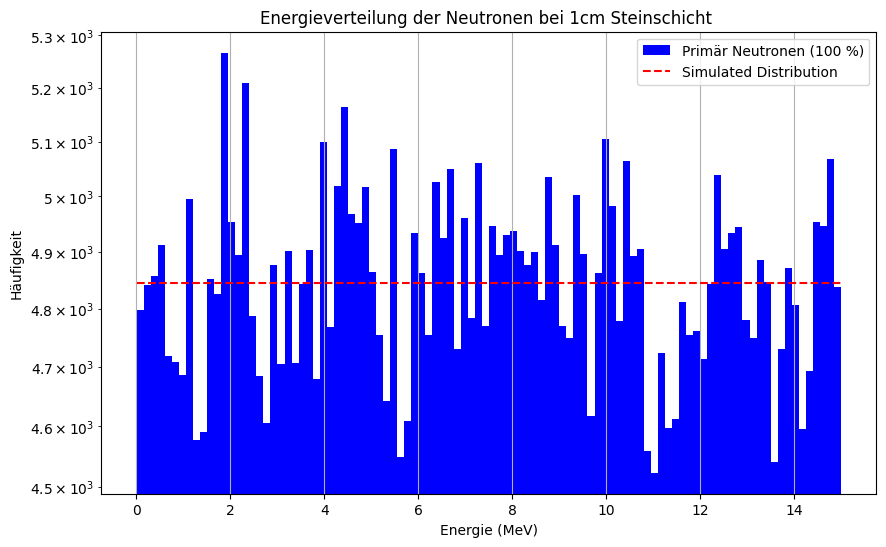

484533 1277307 1681689


12453

In [56]:
conn = sqlite3.connect("1cmConcrete.db")
vergl = np.loadtxt("/home/b/bkoberg/AGW_LowRad/home/bkoberg/XeSim/notebooks/ConstantDistribution.txt", skiprows=2)

df_pri = pd.read_sql("SELECT e_pri, type_pri FROM 'Primary'", conn)
df_Save = pd.read_sql("SELECT Save_e, Save_desc, Save_type FROM 'Save'", conn)



e_pri = aw.to_numpy(df_pri['e_pri'][df_pri['type_pri'] == 'neutron'])/1000
e_con = aw.to_numpy(df_Save['Save_e'][(df_Save['Save_desc'] == 'entering Concrete from Rock') & (df_Save['Save_type'] == 'neutron')])
e_air = aw.to_numpy(df_Save['Save_e'][(df_Save['Save_desc'] == 'entering Air from Concrete') & (df_Save['Save_type'] == 'neutron')])


bins = 100

x = np.linspace(0.01, 15, bins)
y = np.ones(bins)/100


print(np.mean(e_pri), y[0]*e_pri.__len__())
 

# Histogramm erstellen
plt.figure(figsize=(10, 6))
plt.grid()
plt.yscale('log')
plt.hist(e_pri, bins=bins, color='blue', label='Primär Neutronen (100 %)')
#plt.hist(e_con, bins=bins, color='orange', alpha=0.5, label=f'Concrete Neutronen ({e_con.__len__()/e_pri.__len__()*100:.2f} %)')
#plt.hist(e_air, bins=bins, color='green', alpha=0.5, label=f'Air Neutronen ({e_air.__len__()/e_pri.__len__()*100:.2f} %)')
#plt.plot(vergl[:,0], vergl[:,1]*e_pri.__len__(), color='red', label='Simulated Distribution', linestyle='--')
plt.plot(x, y*e_pri.__len__(), color='red', label='Simulated Distribution', linestyle='--')


# Achsentitel und Diagrammtitel
plt.xlabel('Energie (MeV)')
plt.ylabel('Häufigkeit')
plt.title('Energieverteilung der Neutronen bei 1cm Steinschicht ')
plt.legend()

# Diagramm anzeigen
plt.show()

print(e_pri.__len__(), e_con.__len__() ,e_air.__len__())


del df_pri, df_Save, e_pri, e_con, e_air
gc.collect()

## Rest

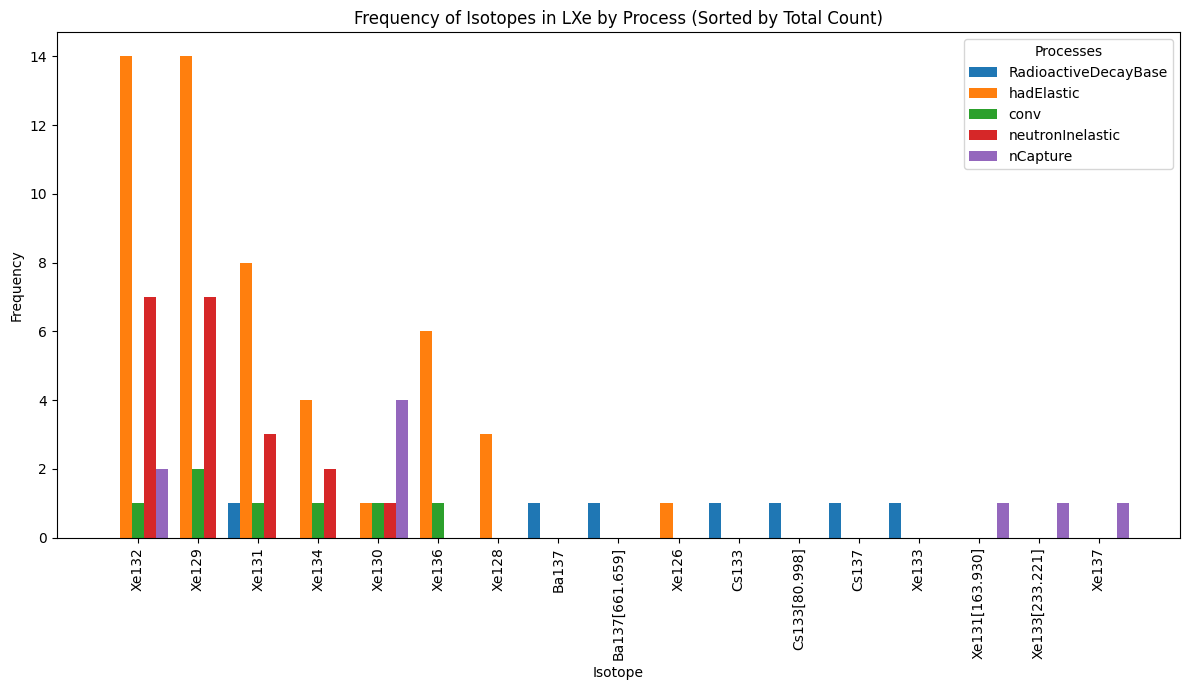

In [ ]:

df_NAct = pd.read_sql("SELECT NAct_volume, NAct_name, NAct_process FROM 'NAct'", conn)

df_NAct = df_NAct[df_NAct['NAct_volume'] == 'LXe']


# Gruppiere die Daten nach 'NAct_name' und 'NAct_process'
counted_elements = df_NAct.groupby(['NAct_name', 'NAct_process']).size().reset_index(name='count')

# Berechne die Gesamthöhe (Summe der Counts) für jede Kategorie
total_counts = counted_elements.groupby('NAct_name')['count'].sum().reset_index()
total_counts = total_counts.sort_values(by='count', ascending=False)

# Sortiere die Kategorien basierend auf der Gesamthöhe
sorted_categories = total_counts['NAct_name'].values

# Extrahiere die eindeutigen Prozesse
processes = counted_elements['NAct_process'].unique()

# Breite der Bars
bar_width = 0.2

# x-Positionen für die Kategorien
x_positions = np.arange(len(sorted_categories))

# Erstelle die Bars für jeden Prozess
fig, ax = plt.subplots(figsize=(12, 7))
for i, process in enumerate(processes):
    # Filtere die Daten für den aktuellen Prozess
    process_data = counted_elements[counted_elements['NAct_process'] == process]
    
    # Hole die Counts für die sortierten Kategorien (falls keine Daten vorhanden sind, setze sie auf 0)
    counts = [process_data[process_data['NAct_name'] == category]['count'].sum() if category in process_data['NAct_name'].values else 0 for category in sorted_categories]
    
    # Zeichne die Bars mit einem Offset basierend auf der Bar-Breite
    ax.bar(x_positions + i * bar_width, counts, bar_width, label=process)

# Achsentitel und Labels
ax.set_xlabel('Isotope')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Isotopes in LXe by Process (Sorted by Total Count)')
ax.set_xticks(x_positions + bar_width * (len(processes) - 1) / 2)
ax.set_xticklabels(sorted_categories, rotation=90)
ax.legend(title="Processes")

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

NAct_process    RadioactiveDecayBase  conv  hadElastic  nCapture  \
NAct_name                                                          
Xe132                            0.0   1.0        14.0       2.0   
Xe129                            0.0   2.0        14.0       0.0   
Xe131                            1.0   1.0         8.0       0.0   
Xe134                            0.0   1.0         4.0       0.0   
Xe130                            0.0   1.0         1.0       4.0   
Xe136                            0.0   1.0         6.0       0.0   
Xe128                            0.0   0.0         3.0       0.0   
Ba137                            1.0   0.0         0.0       0.0   
Ba137[661.659]                   1.0   0.0         0.0       0.0   
Xe126                            0.0   0.0         1.0       0.0   
Cs133                            1.0   0.0         0.0       0.0   
Cs133[80.998]                    1.0   0.0         0.0       0.0   
Cs137                            1.0   0.0      

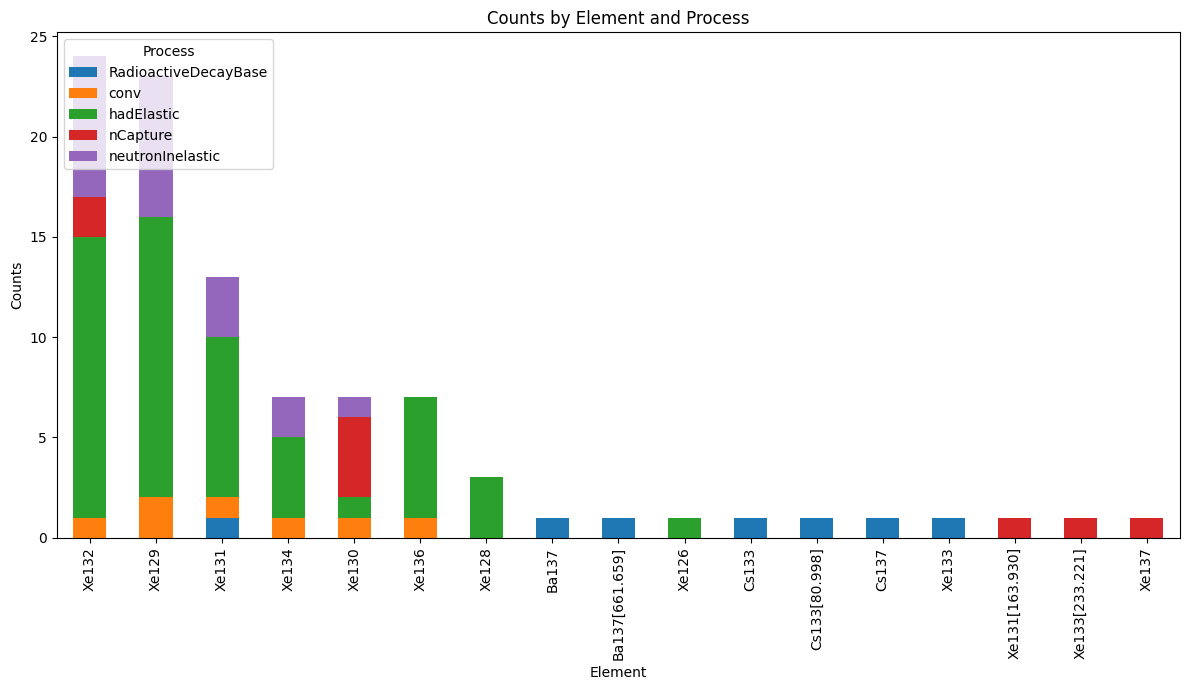

10271

In [ ]:
df_NAct = pd.read_sql("SELECT NAct_volume, NAct_name, NAct_process FROM 'NAct'", conn)

df_NAct = df_NAct[df_NAct['NAct_volume'] == 'LXe']

# Gruppiere die Daten nach 'NAct_name' und 'NAct_process'
counted_elements = df_NAct.groupby(['NAct_name', 'NAct_process']).size().reset_index(name='count')

# Pivot-Tabelle erstellen: Jede Spalte repräsentiert einen Prozess
pivot_table = counted_elements.pivot(index='NAct_name', columns='NAct_process', values='count').fillna(0)

# Sortiere die Pivot-Tabelle nach der Gesamtsumme der Counts (absteigend)
pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Optional: Sortiere die Spalten alphabetisch (falls gewünscht)
pivot_table = pivot_table[sorted(pivot_table.columns)]
print(pivot_table)

# Optional: Visualisierung der sortierten Tabelle
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Counts by Element and Process')
plt.xlabel('Element')
plt.ylabel('Counts')
plt.legend(title='Process', loc='upper left')
plt.tight_layout()
plt.show()

del df_NAct, counted_elements, pivot_table
gc.collect()

In [ ]:
# Pfad für Dateien
path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_*.root"

# Dateien abrufen und begrenzen auf die ersten zwei
files = glob.glob(path)[:2]
print(files)

# Chunk-Größe festlegen (z. B. 10.000 Events pro Patch)
batch_size = 10000

# Filter für die relevanten Felder
fields_to_filter = [
    "e_pri", "xp_pri", "yp_pri", "zp_pri", "type_pri",
    "Save_x", "Save_y", "Save_z", "Save_e", "Save_desc",
    "NAct_volume", "NAct_x", "NAct_y", "NAct_z", "NAct_process", "NAct_name",
]

# Verbindung zur SQLite-Datenbank herstellen
db_path = "01mRock.db"
os.remove(db_path)
conn = sqlite3.connect(db_path)

# Dateien iterativ verarbeiten
for idx, file in enumerate(files, start=1):
    print(f"Processing file {idx}/{len(files)}: {file}")
    
    # Iteration über Events in Batches
    for batch in uproot.iterate(f"{file}:events/events", fields_to_filter, step_size=batch_size):
        df_pri = pd.DataFrame(batch[fields_to_filter[:5]])
        df_Save = pd.DataFrame(batch[fields_to_filter[6:10]])
        df_NAct = pd.DataFrame(batch[fields_to_filter[11:]])
        
        # Umwandlung des Awkward-Arrays in ein Pandas DataFrame
        df = pd.DataFrame({
            field: aw.to_numpy(batch[field]) if np.any(aw.is_none(batch[field]))
            else batch[field].to_list()
            for field in batch.fields
        })
        
        # Listen oder Arrays in String-Format umwandeln
        df = df.applymap(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)

        # Datentypen konvertieren und Daten in SQLite speichern
        df = df.convert_dtypes()
        df.to_sql("01mRock", conn, if_exists="append", index=True)

        # Speicher bereinigen
        del df
        gc.collect()

# Datenbankverbindung schließen
print("Processing completed.")


['/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_5.root', '/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_4.root']
Processing file 1/2: /home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_5.root
Processing file 2/2: /home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_4.root
Processing completed.


In [ ]:
path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_*.root"
#path = "/home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/cf30af8/20250416_RockAnalysis/test2_*.root"
files = glob.glob(path)
files = files[:4]

data_parts = []
total_files = len(files)

# Fortschrittsanzeige in der Schleife
for i, file in enumerate(files):
    print(f"Lade Datei {i + 1} von {total_files}: {file}")
    data_parts.append(uproot.open(file)["events/events"].arrays(library="ak"))

# Daten zusammenfügen
data = aw.concatenate(data_parts)
print("Alle Dateien wurden erfolgreich geladen.")


del data_parts
gc.collect()

Lade Datei 1 von 4: /home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_5.root
Lade Datei 2 von 4: /home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_4.root
Lade Datei 3 von 4: /home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_11.root
Lade Datei 4 von 4: /home/b/bkoberg/AGW_LowRad/data_sim/XeSim_Neutron/108392/20250417_RockAnalysis/0.1mRock_19.root
Alle Dateien wurden erfolgreich geladen.


7292

In [ ]:
# Beispiel-Daten (ersetze durch deine Daten)

print(df['volume'].unique())
pos = df.loc[(df['volume']=='Water') | (df['volume']=='LXeContainer'), ['x','y','z','process']].sample(frac=0.1, random_state=1)  # Zufällige Auswahl von 10% der Daten

x = pos['x']  
y = pos['y'] 
z = pos['z']  

points = np.column_stack((x, y, z))

colors = [
    'red' if process == 'nCapture' else 
    'blue' if process == 'RadioactiveDecay' else 
    'green'  # Standardfarbe für alle anderen Prozesse
    for process in pos['process']
]

colors_rgb = np.array([matplotlib.colors.to_rgb(color) for color in colors])


# PyVista-Plot
cloud = pv.PolyData(points)
cloud["colors"] = colors_rgb 
plotter = pv.Plotter()
plotter.add_mesh(cloud, scalars="colors", rgb=True, point_size=5, render_points_as_spheres=True)
plotter.show()

In [ ]:

pos_pri = df_pri[df_pri['type_pri']=='neutron']
pos_pri = pos_pri[['x_pri', 'y_pri', 'z_pri']].sample(frac=0.1, random_state=1)  # Zufällige Auswahl von 10% der Daten



x = pos_pri['x_pri']
y = pos_pri['y_pri']
z = pos_pri['z_pri']

points = np.column_stack((x, y, z))

# PyVista-Plot
cloud = pv.PolyData(points)
plotter = pv.Plotter()
plotter.add_mesh(cloud, color="blue", point_size=1, render_points_as_spheres=True)
plotter.show()

NameError: name 'df_pri' is not defined